# Notes on Convexity of Loss Functions for Classification

> Investigating convexity for simple neural networks
- toc: true
- branch: master
- badges: true
- comments: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- description:  Following up on a question that arose in Week 3 of Andrew Ng's Machine Learning course. 
- image: images/convexity/convexity_header_new.jpg

This is a post where I'm investigating [convexity](https://en.wikipedia.org/wiki/Convex_function) a bit, as it relates to neural networks.

Andrew Ng, in Week 3 of his [Coursera course on Machine Learning](https://www.coursera.org/learn/machine-learning/home/welcome), shows the following image with respect to the "cost function" to be optimized ([this is slide 14 of Lecture 6](https://d18ky98rnyall9.cloudfront.net/_964b8d77dc0ee6fd42ac7d8a70c4ffa1_Lecture6.pdf?Expires=1511481600&Signature=axhpATyHYVHcJnPtXUFN9~PGYBz~RTLyUrApDUaUlEWS19gg3fDjtfQeez45m6b9AQAlcYw0MvLd3sitwkdfwzofJBJ4SwIXnss4nWt-CtiuHCdbYMGz6jjenc0KOPTlDUMcGNvsuDV8SEH1wTRV76pO94IeF85~SyalebsTGFA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)):


![ng_convexity](images/convexity/ng_loss_convexity.png)

I wanted to investigate this: Could I reproduce the two graphs he sketched?   The two different loss functions are the mean squared error (MSE or sometimes just SE) and cross entropy (CE):

$$ MSE = {1\over m}\sum_{i=1}^m \left( y_i - h_i \right)^2 $$

$$ CE =  - {1\over m}\sum_{i=1}^m \left[ y_i \log(h_i) + (1-y_i) \log(1-h_i) \right] $$

where $y_i$ are the true values (0 or 1) and $h_i = h(x_i)$ are the predictions. 

**TL/DR: No I can't reproduce his sketches.  The graph I get for sum of the squared error (SE) doesn't have the wiggles that his drawing on the left does. *(Perhaps he was just doodling an example of an arbitrary non-convex function, rather than the squared loss in particular?)*   Takeways at the bottom of this, re. the difference between a convex *loss function (by itself)* vs. a convex loss for a *problem* -- i.e. the individual terms are convex for either function, but the *sum* of these terms is actually not strictly convex for either function (for this problem). **

I read a few posts about this first...
* [Math StackExchange: Show that logistic regression with squared loss function is non-convex](https://math.stackexchange.com/questions/1985008/show-that-logistic-regression-with-squared-loss-function-is-non-convex/2176466), which includes a link to [this nice demo on Desmos](https://www.desmos.com/calculator/kxz6lzszf9)
* https://math.stackexchange.com/questions/2193478/loss-function-for-logistic-regression
* https://en.wikipedia.org/wiki/Loss_functions_for_classification seems to say that squared loss is convex. ?? 

...but then wanted to try for myself.  As follows:


In [1]:
# preliminary set up. ipympl allows for interactive plots; replace it with inline if not working
#%matplotlib ipympl
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
# basic functions for data operations
def h(x,a,b):                            # h = logistic function.  a is 'weight' and b is 'bias'
    return 1/(1 + np.exp(-(a*x + b)))    # For code below, a & b should be scalars, x can be anything

def classify_x(x, threshold):   
    out = 0*x
    out[x > threshold] = 1.0
    return out

Prediction guess: a = 24.0 , b = -17.5536


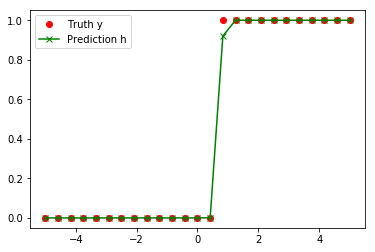

In [3]:
# define some data
num_x = 25
x_arr = np.linspace(-5,5,num_x)          # _arr denotes"array" 
threshold = 0.7314                       # threshold value chosen arbitrarily
y_arr = classify_x(x_arr, threshold)

# make a prediction
a_guess = 10/(x_arr[1]-x_arr[0])
b_guess = -a_guess * threshold
print("Prediction guess: a =",a_guess,", b =",b_guess)
h_arr = np.array(h(x_arr, a_guess, b_guess))

# plot the data
fig = plt.figure()
plt.plot(x_arr, y_arr,'o',color='red',label="Truth y")
plt.plot(x_arr, h_arr,'x-',color='green',label="Prediction h")
plt.legend()
plt.show()

In [4]:
# define a couple loss functions
def calc_se_loss(y_arr, h_arr):  # squared error loss
    return np.mean( (y_arr - h_arr)**2)

def calc_ce_loss(y_arr, h_arr):  # cross-entropy loss, related to Kullback-Liebler divergence
    eps = 1.0e-16   # added to avoid log(0) errors
    return -np.mean( y_arr*np.log(h_arr) + (1-y_arr)*np.log(1-h_arr+eps) )    # elementwise multiplication

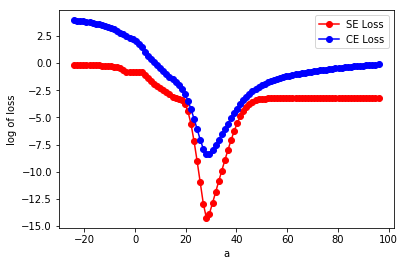

In [5]:
# 1D plot 
# define parameter space over which to plot 
num_a = 100 
a_arr = np.linspace(-a_guess,4*a_guess,num_a)
b_arr = b_guess + 0*a_arr  # make at the b's all the same value for this first plot.

se_loss = []
ce_loss = []
for i in range(a_arr.shape[0]): # cycle through all the values of a and b, getting a different loss for each
    h_arr = h(x_arr, a_arr[i], b_arr[i])
    se_loss.append( calc_se_loss(y_arr, h_arr) ) 
    ce_loss.append( calc_ce_loss(y_arr, h_arr) ) 

# plot 1-d version
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel('a')
#ax.set_ylim(2.38, 2.41)   # zoom in on flat part on the right

plt.plot(a_arr, np.log(se_loss),'o-',color='red',label="SE Loss")
plt.plot(a_arr, np.log(ce_loss),'o-',color='blue',label="CE Loss")
ax.set_ylabel("log of loss")
plt.legend()
plt.show()

In the above figure, it looks like the SE loss goes 'flat' for a bit on the left, but never turns upward until after the global minimum.  The CE loss...I can see a few places where we could connect two points with a straight line and not have all of the line lie with in the [epigraph](https://en.wikipedia.org/wiki/Epigraph_(mathematics)).    Still the lack of flat regions for the blue line would make it preferable for gradient-based optimization. 

## Plot the full error surface

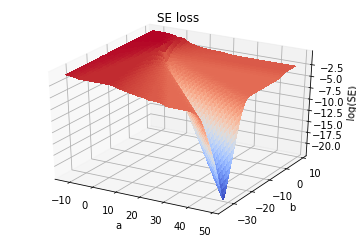

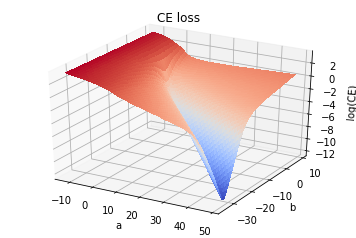

In [6]:
num_a = 100
# try experimenting: play around with the max & min of the a & b values to see the surface
a_arr = np.linspace(-a_guess/2,a_guess*2,num_a)
b_arr = np.linspace(b_guess*2,-b_guess/2,num_a)
A, B = np.meshgrid(a_arr, b_arr)

def plot_loss_surf(A, B, x_arr, loss='SE'):
    Z = np.zeros([len(A), len(B)])
    if ('SE' == loss):
        for i in range(len(A)):
            for j in range(len(B)):
                h_arr = h(x_arr, a_arr[i], b_arr[j])
                Z[j, i] = calc_se_loss(y_arr, h_arr)
    else:
        for i in range(len(A)):
            for j in range(len(B)):
                h_arr = h(x_arr, a_arr[i], b_arr[j])
                Z[j, i] = calc_ce_loss(y_arr, h_arr)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(A, B, np.log(Z), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('log('+loss+')')
    #ax.set_zlim(2, 2.5)
    ax.set_title(loss+' loss')
    #fig.colorbar(surf, shrink=0.5, aspect=5)       # Add a color bar which maps values to colors.
    plt.show()
    
plot_loss_surf(A,B,x_arr,loss='SE')
plot_loss_surf(A,B,x_arr,loss='CE')

## The Verdict
So, although the individual terms  $(y_i - h_i)^2$ and/or $[y_i\log(h_i)+(1-y_i)\log(1-h_i)]$ are individually convex, the *sum* for *either* type of loss terms is actually non-convex for this problem.  Although neither give rise to unwanted local minima for this problem. 

The SE loss, while at least not having any non-global minima, still has multiple significant flat regions that would prove tedious for gradient descent optimiazation, whereas in contrast, the CE loss is smoother and is strictly monotonic on either side of the global minimum.   The the CE loss (and/or KL divergence) would be preferable for this problem -- you could *do* it with SE loss assuming you had momentum or some fancy optimization algorithm, but it would take longer and why bother?

## Aside: Solve the logistic regression problem using scikit-learn

In [7]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(x_arr[:, np.newaxis], y_arr)
a_fit, b_fit = clf.coef_[0][0], clf.intercept_[0]
print("Fit paramters: a =",a_fit,", b =",b_fit)
print("Predicted threshold: x = ",-b_fit/a_fit)

Fit paramters: a = 26.5300439723 , b = -16.5422018244
Predicted threshold: x =  0.623527116718


## Afterward: "But you still haven't found the global minimum!"
In the surface plots above, we see the minimum of the surface going lower and lower -- even lower than the supposedly 'optimum' parameters we just found via scikit-learn.  The reason is that there is no optimal paramter combination:  The steepness parameter $a$ of the sigmoid function $h(x)$ is only bounded from below by the data in this problem. Thus there is no upper bound.  The data will constrain the center of the sigmoid $x_0 = -b/a$ to some extent (i.e. it needs to lie between two values of $x_i$), but other than that...

So how then does the loss function seem to get lower and lower?  The steeper the sigmoid function, the more closely its values will approach 0 and 1 on either side.  Thus for this problem, the optimal solution is $a \rightarrow \infty$, with $b = -({\rm threshold})/a$.

## Comments?
I'm making this up as I go.  You fellow internet users are my collaborators.  Any thoughts?